# Initial imports

In [5]:
import pickle
import numpy as np
import scipy.sparse as ss
import datetime
import networkx as nx
import matplotlib.pyplot as plt

#### IMPORT DATA ####

data_source_2014 = 'TrainSet2014_3.pkl'
data_source_2017 = 'CompetitionSet2017_3.pkl'

graph_2014, unconnected_2014, year_start, years_delta = pickle.load(open(data_source_2014, "rb" ) )

graph_2017, unconnected_2017, year_start, years_delta = pickle.load(open(data_source_2017, "rb" ) )


with open('TrainSet2014_3_solution.pkl', "rb" ) as pkl_file:
        unconnected_vertex_pairs_solution = pickle.load(pkl_file)

ground_truth = np.array(unconnected_vertex_pairs_solution)

NUM_OF_VERTICES = 64719 # number of vertices of the semantic net
NUM_OF_EDGES_2014    = graph_2014[:, 0].size
NUM_OF_EDGES_2017    = graph_2017[:, 0].size

# Building adjacency matrix with no time-weights

For now we completely disregard the time-stamps in the data.

In [6]:
# The concatenation is used to produce a symmetric adjacency matrix
data_rows_2014 = np.concatenate([graph_2014[:, 0], graph_2014[:, 1]])
data_cols_2014 = np.concatenate([graph_2014[:, 1], graph_2014[:, 0]])
data_ones_2014 = np.ones(len(data_rows_2014), np.uint32)

adjM_2014 = ss.csr_matrix((data_ones_2014, (data_rows_2014, data_cols_2014)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))

data_rows_2017 = np.concatenate([graph_2017[:, 0], graph_2017[:, 1]])
data_cols_2017 = np.concatenate([graph_2017[:, 1], graph_2017[:, 0]])
data_ones_2017 = np.ones(len(data_rows_2017), np.uint32)

adjM_2017 = ss.csr_matrix((data_ones_2017, (data_rows_2017, data_cols_2017)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))

#### BUILD DEGREE VECTOR ####

degree_vec_2014 = np.asarray(adjM_2014.sum(1)).flatten()
degree_vec_2017 = np.asarray(adjM_2017.sum(1)).flatten()

print("Imported", data_source_2014,"for training.")
print("\nBuilt adjacency matrix with:")
print(" - ", NUM_OF_VERTICES, " vertices")
print(" - ", NUM_OF_EDGES_2014, " edges\n")
print("Found ", np.count_nonzero(degree_vec_2014 == 0)," unconnected nodes.")

Imported TrainSet2014_3.pkl for training.

Built adjacency matrix with:
 -  64719  vertices
 -  2278611  edges

Found  27230  unconnected nodes.


# Data analysis

In this challenge we are tasked with ordering a list of 1 million pairs of nodes according to which pairs are most likely to appear. To get a better intuition on how to build our model, it is useful to do some preliminary analysis on the network data with the goal of finding principles underlying the data structure. We start by checking how each pair of nodes to be predicted is currently connected to the network.

In [7]:
# Change between 2014 or 2017
test_data  = unconnected_2014
degree_vec = degree_vec_2014

pred_degree0 = degree_vec[test_data[:,0]]
pred_degree1 = degree_vec[test_data[:,1]]

# Counts how many links between two nodes with k = 0:
k0 = np.count_nonzero((pred_degree0 + pred_degree1) == 0)
# Counts how many links between one nodes with k = 0 and one k > 0:
k1 = np.count_nonzero(pred_degree0 * pred_degree1 == 0) - np.count_nonzero((pred_degree0 + pred_degree1) == 0)
# Counts how many links between two nodes with k > 0:
k2 = np.count_nonzero((pred_degree0 * pred_degree1) > 0)

print("Out of 1.000.000 new links:")
print(k0," are between two vertices with degree = 0;")
print(k1," are between one vertex with degree = 0 and one with degree > 0;")
print(k2," are between two vertices with degree > 0s;")

Out of 1.000.000 new links:
265966  are between two vertices with degree = 0;
500060  are between one vertex with degree = 0 and one with degree > 0;
233974  are between two vertices with degree > 0s;


The previous information is useful, because some models are incapable of scoring links that don't belong to the same connected component. Both in the training and competition data there is a significant number of links to be predicted between pairs where at least one of the nodes is disconnected from the network.

We now look at the degree distribution of the whole network. Usually, in complex networks, it follows a power law:
\begin{equation}
P(k)\propto k^{-\gamma},
\end{equation}
with $\gamma>2$. Values in the $2<\gamma<3$ range are common, and it is a region of interest since the second moment of the distribution diverges. Networks with $\gamma\leq 2$ are not well defined given that in such scenario the average degree diverges.
A scale free distribution can be explained from a preferential attachment process, where new nodes that are add the network tend to connect to node with higher degree than nodes with low degree as
\begin{equation}
\Pi(k_i)\propto k_i+B,
\end{equation} 
 with $\Pi(k_i)$ being the probability that a new node connects to a node with degree $k_i$, and $B$ being just a constant. The higher the value of $B$ is, the less relevant the degree of the nodes is. $B$ can be related to $\gamma$ as $\gamma=4+B$. Lower values of $\gamma$, means that new nodes added to the network are more likely to be connect to nodes with higher degrees. Although this model doesn’t consider new links that are created between nodes that are already part of the network, the same principle can be easily generalized to such a scenario.

<Figure size 432x288 with 0 Axes>

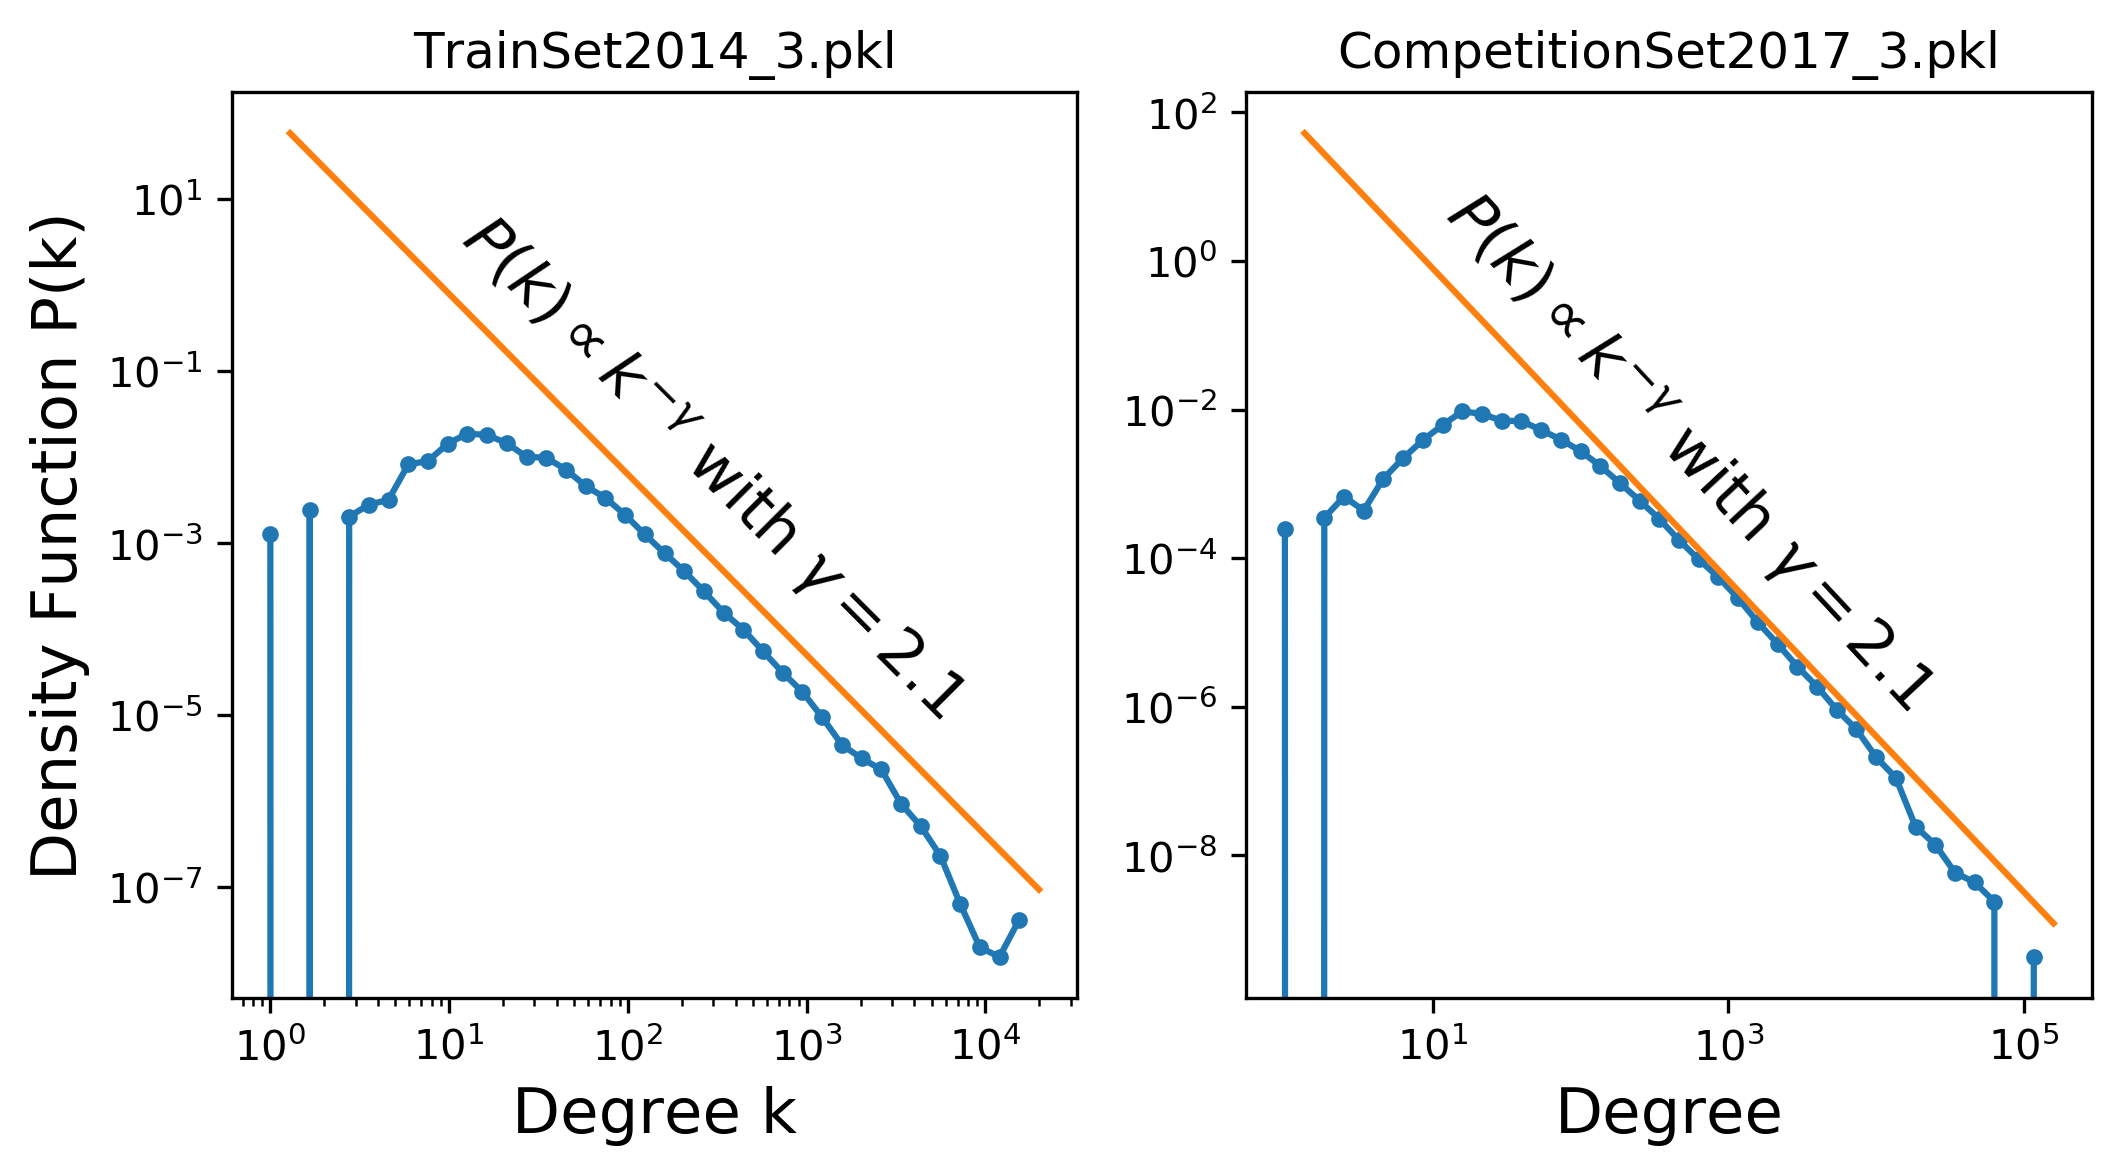

In [8]:
bins_2014 = np.logspace(np.log10(1), np.log10(max(degree_vec)+0.001), num=40);
bins_2017 = np.logspace(np.log10(1), np.log10(max(degree_vec_2017)+0.001), num=40);

[Y0, X0] = np.histogram(degree_vec, bins = bins_2014, density=True);
[Y1, X1] = np.histogram(degree_vec_2017, bins = bins_2017, density=True);

plt.clf();
#plt.rcParams['figure.figsize'] = [5, 1]
plt.figure(figsize=(8,4), dpi = 300)
plt.subplot(121)
plt.title(data_source_2014 ,fontsize=12);
plt.loglog(X0[0:-1],Y0,'.-');
plt.loglog(X0[1:],10**(2)*X0[1:]**(-2.1));
plt.ylabel(r'Density Function P(k)',fontsize=15);
plt.xlabel(r'Degree k',fontsize=15);
plt.annotate(r'$P(k)\propto k^{-\gamma}$ with $\gamma=2.1$',xy=(10, 0.00001),rotation=-45,fontsize=15);
plt.subplot(122)
plt.title(data_source_2017 ,fontsize=12);
plt.loglog(X1[0:-1],Y1,'.-');
plt.loglog(X1[1:],10**(2)*X1[1:]**(-2.1));
plt.xlabel(r'Degree',fontsize=15);
plt.annotate(r'$P(k)\propto k^{-\gamma}$ with $\gamma=2.1$',xy=(10, 0.000001),rotation=-47,fontsize=15);
plt.savefig('degree_distribution.pdf')
plt.show();

In this network we find a very low value of $\gamma$, close to 2. Thefore this network strongly favors new connections between nodes with high degress. This makes sense since in new science there is often a tendency to connect popular concepts.

# Defining simple prediction methods

### Preferential Attachment

In [9]:
def pa_method(adjM, links_to_score):
    # adjM is assumed to be a sparse matrix
    # links_to_score is a list of pairs of nodes (v1, v2)
    # returns a list of scores for each pair in links_to_score
    
    degree_vec = np.asarray(adjM.sum(1)).flatten()
    
    pred_degree_0 = degree_vec[links_to_score[:,0]]
    pred_degree_1 = degree_vec[links_to_score[:,1]]
    
    score_list = pred_degree_0 + pred_degree_1
    
    return score_list/max(score_list)

### Adamic-Adar

In [10]:
def aa_method(adjM, links_to_score):
    
    degree_vec = np.asarray(adjM.sum(1)).flatten()
    
    non_zero = 0.0001
    r, c  = adjM.nonzero()
    rD_sp = ss.csr_matrix(((1.0/(np.log(degree_vec+non_zero)+non_zero))[r], (r,c)), shape = (adjM.shape))
    adjM_tilde = adjM.multiply(rD_sp)
    
    rows = np.unique(links_to_score[:,0])
    cols = np.unique(links_to_score[:,1])
    
    p_matrix = adjM[rows,:]*adjM_tilde[:,cols]
    
    p_matrix = p_matrix + p_matrix.T
    
    # Note that p_matrix has dimensions size(rows)*size(rows). As it happens in the data from the
    # competition the indices in unconnected_vertex_pairs actually only go up to size(rows), which means
    # that we can use those same indices to call values from p_matrix. If that were not the case,
    # we would have to implement a dictionary here to correct the indices before calling values from
    # p_matrix. I checked and in the competition data the same thing happens, and so I didn't implement
    # the dictionary.

    score_list = np.array(p_matrix[links_to_score[:,0], links_to_score[:,1]]).flatten()
    
    return score_list/max(score_list)

# Testing the methods on the training data

Skip to the end if running on the competition data.

In [11]:
print(datetime.datetime.now().time())

print("Computing PA scores...")
score_list_pa = pa_method(adjM_2014, unconnected_2014)
print("Done!")

print("Computing AA scores...")
score_list_aa = aa_method(adjM_2014, unconnected_2014)
print("Done!")

print(datetime.datetime.now().time())

14:22:34.874516
Computing PA scores...
Done!
Computing AA scores...
Done!
14:22:42.370538


## AUC function (for 2014 -> 2017 predictions)

In [12]:
# We use the AUC function from scikit-learn which is faster than the one in the tutorial
from sklearn.metrics import roc_auc_score

# The scikit-learn AUC function uses the array of scores directly:
AUC_PA  = roc_auc_score(ground_truth, score_list_pa)
AUC_AA  = roc_auc_score(ground_truth, score_list_aa)

print("Training data AUC:\n")
print("- PA Method: ", AUC_PA)
print("- AA Method: ", AUC_AA)

Training data AUC:

- PA Method:  0.8029338991694484
- AA Method:  0.6892767257750976


PA performs much better than AA on the training data, probably because AA is only scoring 1/4 of the links (the ones between nodes with degree > 0).

## Combining results

Let us now see if we can get even better results by combining two of the previous methods with a greedy parameter search. We considered the combination of Preferential Attachment with Adamic Adar. We already saw that PA alone is the best performing method, but this method is completely independent of the node distance inside the network. We now test if the addition of a contribution given by the number of common neighbours is able to improve over PA. We define:

$$scores = a \times scores_\text{AA} + (1-a) \times scores_\text{PA}$$

And search for the optimal "a" between 0 and 1.

In [13]:
step   = 0.01
a_list = np.arange(0, 1 + step, step)
AUC_save = []

for a in a_list:
    combined_scores = a*score_list_aa + (1-a)*score_list_pa
    AUC = roc_auc_score(ground_truth, combined_scores)
    AUC_save.append([a, AUC])

AUC_save = np.array(AUC_save)

max_AUC_pos = AUC_save[:,1].argmax()
a = AUC_save[max_AUC_pos, 0]

print("Found max AUC", AUC_save[max_AUC_pos, 1], "for a =", a)

Found max AUC 0.8087304878797116 for a = 0.92


Indeed we see that joining both methods slightly improves the results.

# Building a time-weighted adjacency matrix

So far we have completely ignored the time stamps attached to each link in the data. These time stamps correspond to the date when each link was added to the network, counted as the total number of days since a reference date. In order to include this information in the model, we chose to use it directly as a weight on each link. We consider the following hypothesis:

- The most important links are the very old ones and the very recent ones. The reasoning is that very old links correspond to early connections between concepts, which have had a lot of time to mature and become rooted in the field. The very recent links correspond to the latest connections between concepts, corresponding to the current hot-topic being studied in the field.

In order to quantify and test this hypothesis we normalized the time stamp to a value t between 0 and 1, and tested different polynomial functions f(t) producing weights in the links.

### Grid searching optimal polynomial parameters (don't run, saved below):

In order to optimize a polynomial of the type
\begin{equation}
f(t)= \theta_0 + (\theta_2(t-\theta_1))^{\theta_3}
\end{equation}
we run a grid search on $(\theta_0, \theta_1, \theta_2, \theta_3)$ while saving the AUC for the Preferential Attachment method, since it is the quickest to run.

Other optimization methods were tested, but ultimately this produced the best results.

In [25]:
# Normalizing the time-stamps
times = graph_2014[:, 2] - graph_2014[:, 2].min()
t     = times/times.max()

def polynomial(x, theta0, theta1, theta2, theta3):
    return theta0 + (theta2*(x-theta1))**theta3

non_zero = 0.001
delta_0  = 0.1
delta_1  = 0.01
delta_2  = 1.0

theta0_range = np.arange(0.0 + non_zero, 0.5 + non_zero + delta_0, delta_0)
theta1_range = np.arange(0.45, 0.55, delta_1)
theta2_range = np.arange(1, 5 + delta_2, delta_2)
theta3_range = np.arange(2, 11, 2)


AUC_save = []

for theta3 in theta3_range:
    print("Current power:", theta3)
    for theta0 in theta0_range:
        for theta2 in theta2_range:
            for theta1 in theta1_range:
                        
                times_norm = polynomial(t, theta0, theta1, theta2, theta3)
                times_norm = np.concatenate([times_norm, times_norm])
                adjM_weighted = ss.csr_matrix((times_norm, (data_rows_2014, data_cols_2014)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))
                score_list_pa_time = pa_method(adjM_weighted, unconnected_2014)
                AUC_PA_sk_time = roc_auc_score(ground_truth, score_list_pa_time)
                        
                AUC_save.append([AUC_PA_sk_time, theta0, theta1, theta2, theta3])

AUC_save = np.array(AUC_save)

max_AUC_pos = AUC_save[:,0].argmax()

print("Found max AUC", AUC_save[max_AUC_pos, 0],"for:")
print(AUC_save[max_AUC_pos, 1:5])

#theta0 = 0.0
#theta1 = 0.45
#theta2 = 3
#theta3 = 6

Current power: 2
Current power: 4
Current power: 6
Current power: 8
Current power: 10
Found max AUC 0.8136713130746505 for:
[1.0e-03 4.5e-01 3.0e+00 6.0e+00]


### Running methods with time weights:

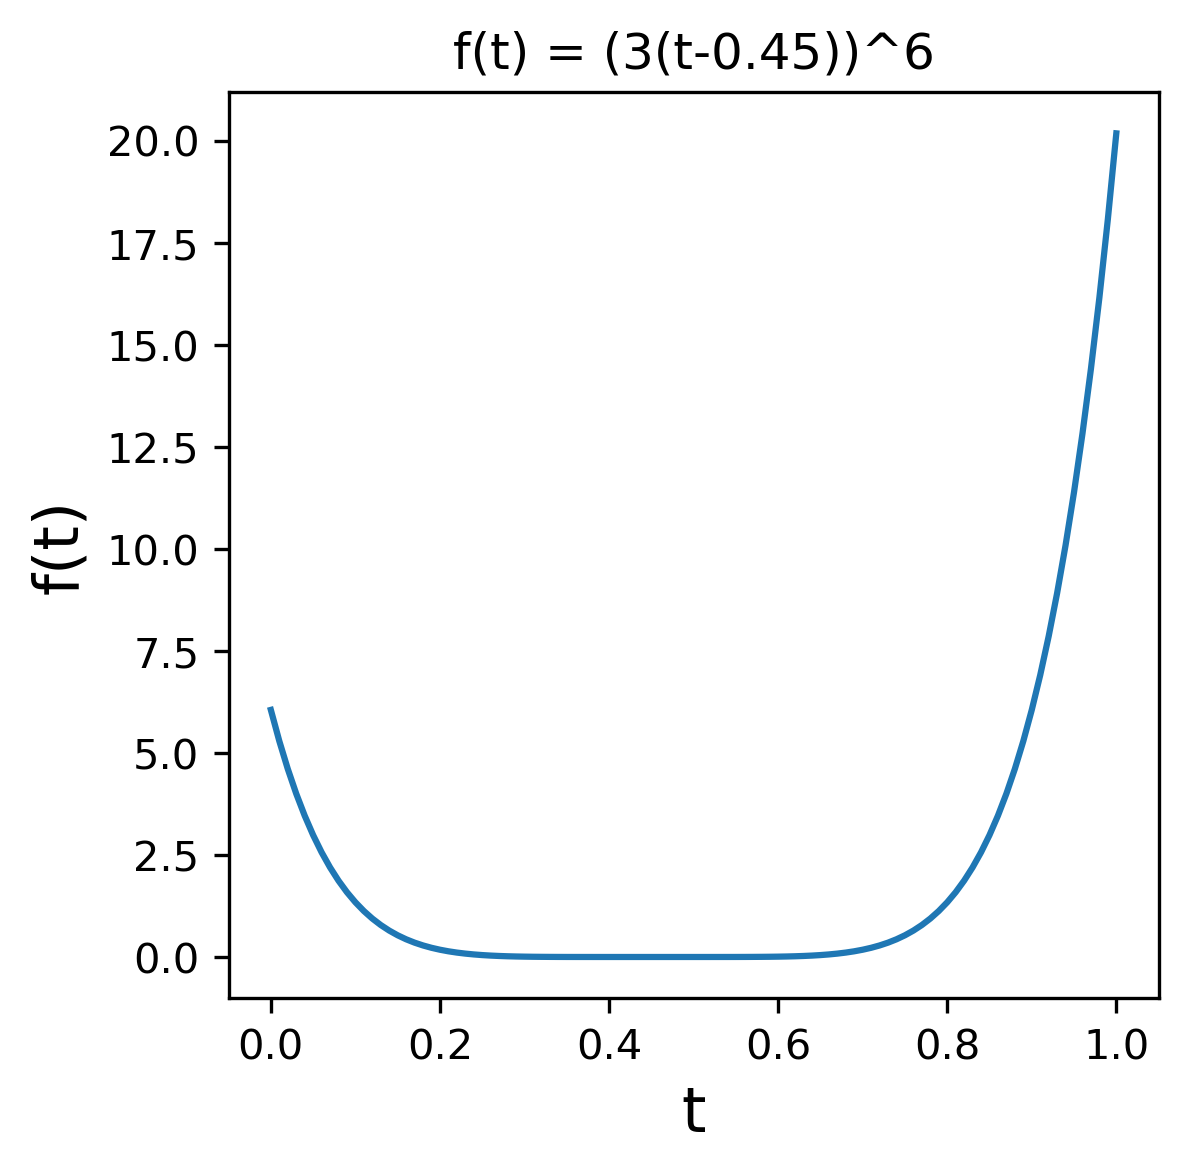

Using scikit-learn AUC function:
- PA Method:  0.8136720715779155
- AA Method:  0.6882913832630044


In [14]:
def polynomial(x, x0, x1, a, b):
    return x0 + (a*(x-x1))**b

# Normalizing the time-stamps
times = graph_2014[:, 2] - graph_2014[:, 2].min()
t     = times/times.max()

theta0 = 0.0
theta1 = 0.45
theta2 = 3
theta3 = 6

delta = 0.01
x = np.arange(0, 1+delta, delta)
plt.figure(figsize=(4,4), dpi = 300)
plt.plot(x , polynomial(x, theta0, theta1, theta2, theta3))
plt.title("f(t) = (3(t-0.45))^6" ,fontsize=12);
plt.ylabel(r'f(t)',fontsize=15);
plt.xlabel(r't',fontsize=15);
plt.savefig('time_function.pdf')
plt.show()

# Polynomial function of the time-stamps
times_norm = polynomial(t, theta0, theta1, theta2, theta3)
times_norm = np.concatenate([times_norm, times_norm])

# Building the weighted adjacency matrix
adjM_weighted = ss.csr_matrix((times_norm, (data_rows_2014, data_cols_2014)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))

score_list_pa_time = pa_method(adjM_weighted, unconnected_2014)
score_list_aa_time = aa_method(adjM_weighted, unconnected_2014)

AUC_PA_time = roc_auc_score(ground_truth, score_list_pa_time)
AUC_AA_time = roc_auc_score(ground_truth, score_list_aa_time)

print("Using scikit-learn AUC function:")
print("- PA Method: ", AUC_PA_time)
print("- AA Method: ", AUC_AA_time)

The values found for the polynomial parameters make a small improvement in the PA method, while leaving the AA result roughly unchanged. While it is possible to find a more optimimal set of parameters for the AA method, we ultimately found that this improvement did not translate to the competition set. The best results we obtained in the competition used the same parameters for both the PA and AA method.

We now run the same combination procedure as before:

In [43]:
step   = 0.01
a_list = np.arange(0, 1 + step, step)
AUC_save = []

for a in a_list:
    combined_scores = a*score_list_aa_time + (1-a)*score_list_pa_time
    AUC = roc_auc_score(ground_truth, combined_scores)
    AUC_save.append([a, AUC])

AUC_save = np.array(AUC_save)

max_AUC_pos = AUC_save[:,1].argmax()
a = AUC_save[max_AUC_pos, 0]

print("Found max AUC",AUC_save[max_AUC_pos, 1],"for a =", a)

Found max AUC 0.8181607332514914 for a = 0.9500000000000001


The combination of the PA and AA method with the defined time-weighted adjacency matrix produce the best results yet. We can now test our different methods on the competition data.

# Running on the competition data (2017)

In [49]:
import pickle
import numpy as np
import scipy.sparse as ss
import datetime

# Normalizing the time-stamps
times = graph_2017[:, 2] - graph_2017[:, 2].min()
t     = times/times.max()

# Polynomial function of the time-stamps

theta0 = 0.5
theta1 = 0.5
theta2 = 3
theta3 = 6

# Although this parameter set is not what comes out of our training, 
# we manually found it to perform better in the competition set.

times_norm = polynomial(t, theta0, theta1, theta2, theta3)
times_norm = np.concatenate([times_norm, times_norm])

# Building the weighted adjacency matrix
adjM_weighted = ss.csr_matrix((times_norm, (data_rows_2017, data_cols_2017)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))

In [41]:
#score_list_pa = pa_method(adjM_2017, unconnected_2017)
#score_list_aa = aa_method(adjM_2017, unconnected_2017)

score_list_pa_time = pa_method(adjM_weighted, unconnected_2017)
score_list_aa_time = aa_method(adjM_weighted, unconnected_2017)

a = 0.95

#combined_scores    = a*score_list_aa + (1-a)*score_list_pa
combined_scores_time = a*score_list_aa_time + (1-a)*score_list_pa_time

sorted_predictions = np.argsort(-1.0*combined_scores_time)

# Exporting a submission file

In [49]:
import json

# Save the results for submission.
submit_file = "pa_time.json"

all_idx_list_float=list(map(float, sorted_predictions))
with open(submit_file, "w", encoding="utf8") as json_file:
    json.dump(all_idx_list_float, json_file)
    
print("Solution stored as "+submit_file+".\nLooking forward to your submission.")

Solution stored as pa_time.json.
Looking forward to your submission.
